In [ ]:
# Read the Feature engineering DataSet

#!wget --header="Host: doc-0s-0c-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Cookie: AUTH_g6rouv7anedfrrf7ue0ns472lo11dqgi=03254098180734767806|1614742425000|cfjmbicf1q4767icnumc38udgo14vusd; AUTH_g6rouv7anedfrrf7ue0ns472lo11dqgi_nonce=295ef8iahte76" --header="Connection: keep-alive" "https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/pblgkejb48lv4je87rr0ale25k6q65pa/am426bad5o7bj737hbqlbub7p7p2aevd/1614742725000/03254098180734767806/03254098180734767806/1eOWhua4r1ZVzvP1yuTnPXi_RbOcrbmjf?e=download&authuser=0&nonce=295ef8iahte76&user=03254098180734767806&hash=2uv1ibqha1luhi8r4daut94ncvngqvjs" -c -O 'Data_m5.pkl'

In [ ]:
# Import all The Library

import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm
import joblib
import random

In [ ]:
# Read The Data

df_m = pd.read_pickle("Data_m5.pkl")

In [ ]:
# Size of DataFrame

df_m.shape

(27023821, 47)

In [ ]:
df_m.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,event_name_1_Cinco De Mayo,event_name_1_Father's day,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_Ramadan starts,event_name_2_Cinco De Mayo,event_name_2_Father's day,event_name_2_OrthodoxEaster,Event_1,Event_2,group_day,sell_price,price_diffrence_2,price_diffrence_4,price_diffrence_8,lag_7,lag_28,rmean_7_7,rmean_7_28,rmean_28_7,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
1,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,d_1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,8.882812,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
2,HOBBIES_1_003_CA_1_evaluation,2,0,0,0,0,d_1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.880859,-0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
3,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,d_1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,1.780273,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
4,HOBBIES_1_005_CA_1_evaluation,4,0,0,0,0,d_1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,3.279297,-0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13


In [ ]:
# Fill Zero Values

for c in [c for c in df_m.columns.tolist() if 'rm_diff_price_' in c]:
    df_m[c].fillna(0, inplace=True)

In [ ]:
# Get integer value in d column    ex d_1 , d_2   ---->>>   1  ,1

df_m['d'] = df_m['d'].apply(lambda a: a.split('_')[1]).astype(np.int16)

In [ ]:
# Training DataSet

df = df_m[df_m['d']<=1941]

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,event_name_1_Cinco De Mayo,event_name_1_Father's day,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_Ramadan starts,event_name_2_Cinco De Mayo,event_name_2_Father's day,event_name_2_OrthodoxEaster,Event_1,Event_2,group_day,sell_price,price_diffrence_2,price_diffrence_4,price_diffrence_8,lag_7,lag_28,rmean_7_7,rmean_7_28,rmean_28_7,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
1,HOBBIES_1_002_CA_1_evaluation,1,0,0,0,0,1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,8.882812,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
2,HOBBIES_1_003_CA_1_evaluation,2,0,0,0,0,1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.880859,-0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
3,HOBBIES_1_004_CA_1_evaluation,3,0,0,0,0,1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,1.780273,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13
4,HOBBIES_1_005_CA_1_evaluation,4,0,0,0,0,1050,0.0,2013-12-13,11346,0,7,12,2013,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,3.279297,-0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,50,4,13


In [ ]:
df.shape

(26170101, 47)

In [ ]:
# Categorical Feature 

cat_feats = (['item_id','store_id', 'cat_id', 'state_id','dept_id'] 
              + ["event_type_1", "event_type_2"]
              + ['wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI'])

In [ ]:
# Columns i want to Remove

useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "sell_price",'event_name_1', 'event_name_2','Event_1','Event_2']

In [ ]:
train_cols = df.columns[~df.columns.isin(useless_cols)]

In [ ]:
# Chosse 500 Random Days For Cross Validation DataSet

days_val = random.choices(df['d'].unique().tolist(), k=500)

In [ ]:
# Training Data
X_train = df[df['d'].isin(days_val)==False][train_cols]
# Training Target Variable
y_train = df[df['d'].isin(days_val)==False]["sales"]

In [ ]:
# Cross Validation Data
X_val = df[df['d'].isin(days_val)==True][train_cols]
# Cross Validation Target Variable
y_val = df[df['d'].isin(days_val)==True]["sales"]

**Modeling Part**

In [ ]:
%%time

learning_rate1 = [0.09,.05,.15]
number_of_Leave = [32,16,8]
lambda_l2 = [0.1,0.2,0.3]
min_data_in_leaf1 = [50,30,20]





for kk in tqdm(range(3)):

    print("Prediction Number  Started ",kk)

    # Instilaize All Variables 
    lr1 = learning_rate1[kk]
    leave1 = number_of_Leave[kk]
    reg1 = lambda_l2[kk]
    leaf_data = min_data_in_leaf1[kk]

    params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "learning_rate" : lr1,
        "sub_feature" : 0.9,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : reg1,
        'verbosity': 1,
        'num_iterations' : 2000,
        'num_leaves': leave1,
        "min_data_in_leaf": leaf_data,
    }

    print("*"*50)
    print(params)
    print(" "*50)


    train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats)
    valid_data = lgb.Dataset(X_val, label = y_val, categorical_feature=cat_feats)

    m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                verbose_eval=20, early_stopping_rounds=30) 
    

    model_name = 'lgb'+'_Model_' +str(kk) +'.pkl'
    # save model
    joblib.dump(m_lgb, model_name)
    
    

    feature_imp = pd.DataFrame({'Value':m_lgb.feature_importance(),'Feature':X_train.columns})
    feature_imp = feature_imp.sort_values(by='Value', ascending=False).reset_index(drop=True)
    display(feature_imp.head(20))

    print("*"*50)
    print(" "*50)


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Prediction Number  Started  0
**************************************************
{'objective': 'poisson', 'metric': 'rmse', 'learning_rate': 0.09, 'sub_feature': 0.9, 'sub_row': 0.75, 'bagging_freq': 1, 'lambda_l2': 0.1, 'verbosity': 1, 'num_iterations': 2000, 'num_leaves': 32, 'min_data_in_leaf': 50}
                                                  


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[20]	training's rmse: 2.50952	valid_1's rmse: 2.49352
[40]	training's rmse: 2.31439	valid_1's rmse: 2.30906
[60]	training's rmse: 2.27386	valid_1's rmse: 2.27328
[80]	training's rmse: 2.25998	valid_1's rmse: 2.26219
[100]	training's rmse: 2.24778	valid_1's rmse: 2.25254
[120]	training's rmse: 2.23421	valid_1's rmse: 2.24267
[140]	training's rmse: 2.22278	valid_1's rmse: 2.23453
[160]	training's rmse: 2.21207	valid_1's rmse: 2.22699
[180]	training's rmse: 2.20395	valid_1's rmse: 2.22092
[200]	training's rmse: 2.19588	valid_1's rmse: 2.21446
[220]	training's rmse: 2.18795	valid_1's rmse: 2.20845
[240]	training's rmse: 2.18084	valid_1's rmse: 2.20287
[260]	training's rmse: 2.1739	valid_1's rmse: 2.19805
[280]	training's rmse: 2.16808	valid_1's rmse: 2.19351
[300]	training's rmse: 2.1619	valid_1's rmse: 2.18906
[320]	training's rmse: 2.15602	valid_1's rmse: 2.18445
[340]	training's rmse: 2.1509	valid_1's rmse: 2.18154
[360]	trai

,Value,Feature
0,31045,item_id
1,3473,month
2,3419,rmean_7_7
3,3145,rmean_7_28
4,2835,store_id
5,2689,rmean_28_28
6,1987,rmean_28_7
7,1802,lag_7
8,1740,wday
9,1561,mday


 33%|███▎      | 1/3 [1:06:05<2:12:11, 3965.82s/it]

**************************************************
                                                  
Prediction Number  Started  1
**************************************************
{'objective': 'poisson', 'metric': 'rmse', 'learning_rate': 0.05, 'sub_feature': 0.9, 'sub_row': 0.75, 'bagging_freq': 1, 'lambda_l2': 0.2, 'verbosity': 1, 'num_iterations': 2000, 'num_leaves': 16, 'min_data_in_leaf': 30}
                                                  


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[20]	training's rmse: 2.85462	valid_1's rmse: 2.81841
[40]	training's rmse: 2.521	valid_1's rmse: 2.49659
[60]	training's rmse: 2.37791	valid_1's rmse: 2.36147
[80]	training's rmse: 2.31674	valid_1's rmse: 2.30468
[100]	training's rmse: 2.2875	valid_1's rmse: 2.27897
[120]	training's rmse: 2.27283	valid_1's rmse: 2.26678
[140]	training's rmse: 2.26267	valid_1's rmse: 2.25892
[160]	training's rmse: 2.25511	valid_1's rmse: 2.25286
[180]	training's rmse: 2.24775	valid_1's rmse: 2.24686
[200]	training's rmse: 2.24215	valid_1's rmse: 2.24271
[220]	training's rmse: 2.23608	valid_1's rmse: 2.23803
[240]	training's rmse: 2.23185	valid_1's rmse: 2.23459
[260]	training's rmse: 2.22581	valid_1's rmse: 2.22988
[280]	training's rmse: 2.2196	valid_1's rmse: 2.22435
[300]	training's rmse: 2.21458	valid_1's rmse: 2.22005
[320]	training's rmse: 2.21072	valid_1's rmse: 2.21675
[340]	training's rmse: 2.20828	valid_1's rmse: 2.21494
[360]	train

,Value,Feature
0,16228,item_id
1,1970,rmean_7_7
2,1867,rmean_7_28
3,1167,rmean_28_28
4,1093,store_id
5,1048,month
6,895,lag_7
7,792,rmean_28_7
8,735,wday
9,673,dept_id


 67%|██████▋   | 2/3 [2:05:42<1:04:08, 3848.93s/it]

**************************************************
                                                  
Prediction Number  Started  2
**************************************************
{'objective': 'poisson', 'metric': 'rmse', 'learning_rate': 0.15, 'sub_feature': 0.9, 'sub_row': 0.75, 'bagging_freq': 1, 'lambda_l2': 0.3, 'verbosity': 1, 'num_iterations': 2000, 'num_leaves': 8, 'min_data_in_leaf': 20}
                                                  


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[20]	training's rmse: 2.44134	valid_1's rmse: 2.42163
[40]	training's rmse: 2.37427	valid_1's rmse: 2.36044
[60]	training's rmse: 2.34787	valid_1's rmse: 2.33839
[80]	training's rmse: 2.31286	valid_1's rmse: 2.30625
[100]	training's rmse: 2.28658	valid_1's rmse: 2.28291
[120]	training's rmse: 2.27052	valid_1's rmse: 2.26883
[140]	training's rmse: 2.25221	valid_1's rmse: 2.25174
[160]	training's rmse: 2.24704	valid_1's rmse: 2.24742
[180]	training's rmse: 2.2374	valid_1's rmse: 2.23916
[200]	training's rmse: 2.23184	valid_1's rmse: 2.23429
[220]	training's rmse: 2.22346	valid_1's rmse: 2.22681
[240]	training's rmse: 2.2199	valid_1's rmse: 2.22387
[260]	training's rmse: 2.21533	valid_1's rmse: 2.22068
[280]	training's rmse: 2.21232	valid_1's rmse: 2.2182
[300]	training's rmse: 2.20913	valid_1's rmse: 2.21546
[320]	training's rmse: 2.20719	valid_1's rmse: 2.21381
[340]	training's rmse: 2.20389	valid_1's rmse: 2.21171
[360]	trai

## Testing Purpose


In [ ]:
# For Prediction Purpose i am using This DataFrame

dt = df_m[df_m['d']>=1871]

In [ ]:
dt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,event_name_1_Cinco De Mayo,event_name_1_Father's day,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_Ramadan starts,event_name_2_Cinco De Mayo,event_name_2_Father's day,event_name_2_OrthodoxEaster,Event_1,Event_2,group_day,sell_price,price_diffrence_2,price_diffrence_4,price_diffrence_8,lag_7,lag_28,rmean_7_7,rmean_7_28,rmean_28_7,rmean_28_28,week,quarter,mday
23974822,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1871,0.0,2016-03-13,11607,3,2,3,2016,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,1.0,0.0,0.714355,1.071289,1.286133,0.821289,10,1,13
23974823,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1872,0.0,2016-03-14,11607,1,3,3,2016,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,0.0,0.0,0.714355,1.000000,1.000000,0.821289,11,1,14
23974824,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1873,1.0,2016-03-15,11607,5,4,3,2016,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,0.0,0.0,0.428467,0.928711,0.714355,0.750000,11,1,15
23974825,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1874,1.0,2016-03-16,11607,6,5,3,2016,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4,2.240234,0.0,0.0,-0.0,1.0,0.0,0.571289,0.964355,0.714355,0.714355,11,1,16
23974826,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1875,1.0,2016-03-17,11607,4,6,3,2016,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,0,4,2.240234,0.0,0.0,-0.0,1.0,1.0,0.571289,1.000000,0.856934,0.678711,11,1,17


In [ ]:
dt.shape

(3018510, 47)

In [ ]:
def create_fea(dt):
    
    # Create 2 Lags of 7 Days And 28 Days
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)
        
    
    # Create 4 Rolling Mean 
    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

In [ ]:
# Duration You Want to Predict
h = 28 

# Days For Lag Calculation purpose
max_lags = 70

# First Day Of Prediction
fday = datetime(2016,5, 23) 
fday

datetime.datetime(2016, 5, 23, 0, 0)

In [ ]:
# Predict Sales for 28 Days

for tdelta in range(0, 28):
    day = fday + timedelta(days=tdelta)
    print(day)
    tst = dt[(dt.date >= day - timedelta(days=max_lags)) & (dt.date <= day)]
    create_fea(tst)
    tst = tst.loc[tst.date == day , train_cols]
    te.loc[te.date == day, "sales"] = m_lgb.predict(tst)
    print("Prediction Compltete ",tdelta)
    del(tst)

2016-05-23 00:00:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Prediction Compltete  0
2016-05-24 00:00:00
Prediction Compltete  1
2016-05-25 00:00:00
Prediction Compltete  2
2016-05-26 00:00:00
Prediction Compltete  3
2016-05-27 00:00:00
Prediction Compltete  4
2016-05-28 00:00:00
Prediction Compltete  5
2016-05-29 00:00:00
Prediction Compltete  6
2016-05-30 00:00:00
Prediction Compltete  7
2016-05-31 00:00:00
Prediction Compltete  8
2016-06-01 00:00:00
Prediction Compltete  9
2016-06-02 00:00:00
Prediction Compltete  10
2016-06-03 00:00:00
Prediction Compltete  11
2016-06-04 00:00:00
Prediction Compltete  12
2016-06-05 00:00:00
Prediction Compltete  13
2016-06-06 00:00:00
Prediction Compltete  14
2016-06-07 00:00:00
Prediction Compltete  15
2016-06-08 00:00:00
Prediction Compltete  16
2016-06-09 00:00:00
Prediction Compltete  17
2016-06-10 00:00:00
Prediction Compltete  18
2016-06-11 00:00:00
Prediction Compltete  19
2016-06-12 00:00:00
Prediction Compltete  20
2016-06-13 00:00:00
Prediction Compltete  21
2016-06-14 00:00:00
Prediction Compltete

In [ ]:
te.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI,event_name_1_Cinco De Mayo,event_name_1_Father's day,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_Ramadan starts,event_name_2_Cinco De Mayo,event_name_2_Father's day,event_name_2_OrthodoxEaster,Event_1,Event_2,group_day,sell_price,price_diffrence_2,price_diffrence_4,price_diffrence_8,lag_7,lag_28,rmean_7_7,rmean_7_28,rmean_28_7,rmean_28_28,week,quarter,mday
23974822,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1871,0.0,2016-03-13,11607,3,2,3,2016,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,1.0,0.0,0.714355,1.071289,1.286133,0.821289,10,1,13
23974823,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1872,0.0,2016-03-14,11607,1,3,3,2016,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,0.0,0.0,0.714355,1.000000,1.000000,0.821289,11,1,14
23974824,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1873,1.0,2016-03-15,11607,5,4,3,2016,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3,2.240234,0.0,0.0,-0.0,0.0,0.0,0.428467,0.928711,0.714355,0.750000,11,1,15
23974825,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1874,1.0,2016-03-16,11607,6,5,3,2016,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4,2.240234,0.0,0.0,-0.0,1.0,0.0,0.571289,0.964355,0.714355,0.714355,11,1,16
23974826,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,1875,1.0,2016-03-17,11607,4,6,3,2016,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,0,4,2.240234,0.0,0.0,-0.0,1.0,1.0,0.571289,1.000000,0.856934,0.678711,11,1,17


In [ ]:
# Filter Last 28 Days

x = pd.pivot_table(te, index='id', values='sales', columns='d').iloc[:,-28:]
x

d,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_evaluation,0.810059,0.717285,0.701172,0.752930,0.825684,0.916992,0.758301,0.780273,0.923340,0.798828,0.765625,1.118164,1.175781,1.131836,0.892578,0.668945,0.666504,0.678711,0.752441,0.919922,0.906738,0.677246,0.646973,0.653320,0.652832,0.735352,0.880371,0.687988
FOODS_1_001_CA_2_evaluation,0.750977,0.710938,0.634766,0.622559,0.768066,1.092773,0.765625,0.718750,0.679688,0.778320,0.710938,1.008789,1.175781,1.158203,0.876465,0.720215,0.714844,0.733887,0.836914,1.093750,0.969727,0.713867,0.666504,0.670410,0.640625,0.740234,1.021484,0.721191
FOODS_1_001_CA_3_evaluation,0.890625,0.825684,0.785645,0.752441,1.304688,1.141602,1.205078,1.018555,1.069336,1.128906,1.034180,1.333008,1.304688,1.545898,1.285156,1.062500,0.981934,1.017578,1.063477,1.307617,1.593750,1.210938,1.192383,0.979980,0.980957,1.065430,1.258789,1.143555
FOODS_1_001_CA_4_evaluation,0.269287,0.267822,0.291016,0.300781,0.314941,0.327148,0.300293,0.298096,0.322266,0.344482,0.321289,0.426758,0.438477,0.445801,0.380859,0.307617,0.308838,0.313232,0.339600,0.391602,0.386475,0.313232,0.310547,0.332764,0.321045,0.323486,0.387939,0.289795
FOODS_1_001_TX_1_evaluation,0.501953,0.616211,0.550293,0.630859,0.778809,0.753418,0.874023,0.769531,0.712402,0.798340,0.749023,0.973145,1.073242,1.041992,0.809082,0.664551,0.658203,0.697754,0.766602,0.945312,0.916992,0.738281,0.817871,0.714844,0.697754,0.758789,0.912598,0.749023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_516_TX_2_evaluation,0.202637,0.184570,0.177612,0.172241,0.193848,0.202148,0.198364,0.194214,0.182007,0.187134,0.191528,0.227417,0.238647,0.253906,0.182983,0.162842,0.160278,0.164307,0.180542,0.205078,0.201172,0.164917,0.152100,0.152466,0.152588,0.180786,0.207031,0.203125
HOUSEHOLD_2_516_TX_3_evaluation,0.173462,0.158936,0.153320,0.154907,0.182495,0.207642,0.237915,0.213379,0.216553,0.219727,0.217896,0.294922,0.276367,0.279053,0.214600,0.203735,0.200562,0.192627,0.187500,0.245972,0.222168,0.178589,0.176025,0.192505,0.191528,0.216064,0.242065,0.253906
HOUSEHOLD_2_516_WI_1_evaluation,0.117126,0.108398,0.109375,0.119751,0.181396,0.186768,0.158936,0.140747,0.139404,0.140381,0.131348,0.184204,0.188110,0.201050,0.158325,0.131470,0.129883,0.146606,0.161743,0.176270,0.167969,0.128540,0.125610,0.135986,0.137939,0.162476,0.185059,0.150513


In [ ]:
x.to_csv("sub.csv",index='False')

In [ ]:

a1 = pd.read_csv("sub.csv")
a1

,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
0,FOODS_1_001_CA_1_evaluation,0.84860,0.73730,0.73830,0.7550,0.8076,0.93200,0.88600,0.80130,1.0610,0.91900,0.6950,0.8470,1.0570,1.0360,0.8057,0.76100,0.70900,0.73630,0.82130,1.0210,0.9720,0.76200,0.6780,0.6675,0.6763,0.7725,0.9507,0.8530
1,FOODS_1_001_CA_2_evaluation,0.76660,0.71400,0.68500,0.6343,0.7812,1.09400,0.89200,0.73800,0.8320,0.85300,0.6690,0.7850,1.0205,1.0080,0.7080,0.72000,0.69870,0.72270,0.84330,1.0890,0.9814,0.74800,0.6816,0.6600,0.6123,0.7637,0.9976,0.8410
2,FOODS_1_001_CA_3_evaluation,0.81050,0.71300,0.71630,0.6836,1.2290,1.04600,1.08000,0.91360,1.0660,1.12300,0.7940,0.9897,1.1260,1.0570,0.8740,0.94600,0.90500,0.91940,1.10500,1.3150,1.2880,1.01300,0.9990,0.9230,0.9230,1.0850,1.2850,1.1650
3,FOODS_1_001_CA_4_evaluation,0.26560,0.26700,0.28320,0.3018,0.2957,0.31470,0.31030,0.28150,0.3918,0.35960,0.2542,0.2837,0.3410,0.3198,0.2761,0.29500,0.29080,0.29470,0.33060,0.3738,0.3630,0.30100,0.2952,0.3018,0.3076,0.3218,0.3584,0.3171
4,FOODS_1_001_TX_1_evaluation,0.47880,0.67870,0.54700,0.5660,0.6772,0.65770,0.80270,0.66360,0.8423,0.88230,0.7080,0.7850,0.9330,0.8230,0.6875,0.66800,0.64700,0.69200,0.76000,0.9287,0.9014,0.75400,0.9290,0.6970,0.6987,0.7905,0.9110,0.8440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.20750,0.19180,0.17910,0.1743,0.2048,0.22470,0.24980,0.21750,0.2454,0.21230,0.2167,0.2524,0.2830,0.2790,0.2001,0.16550,0.16440,0.16700,0.19420,0.2213,0.2168,0.16910,0.1649,0.1642,0.1636,0.1840,0.2108,0.2045
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.17880,0.15820,0.14900,0.1486,0.1929,0.22390,0.31450,0.26070,0.3032,0.26200,0.3074,0.3335,0.3218,0.2935,0.2540,0.21790,0.21880,0.21120,0.23350,0.2637,0.2500,0.22100,0.2084,0.2162,0.2147,0.2570,0.2854,0.2722
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.12220,0.11430,0.11536,0.1216,0.1871,0.20980,0.20840,0.15210,0.1715,0.14670,0.1346,0.1816,0.2196,0.2104,0.1504,0.14200,0.15690,0.15900,0.17970,0.2010,0.1951,0.14100,0.1415,0.1461,0.1471,0.1830,0.2150,0.1823
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.12260,0.11690,0.11890,0.1119,0.1267,0.13750,0.12620,0.11395,0.1392,0.13610,0.1222,0.1515,0.1552,0.1503,0.1220,0.11694,0.12090,0.12225,0.14510,0.1621,0.1503,0.12335,0.1220,0.1261,0.1218,0.1346,0.1632,0.1283


In [79]:
sub = pd.read_csv('sample_submission.csv', usecols=['id'])
sub

,id
0,HOBBIES_1_001_CA_1_validation
1,HOBBIES_1_002_CA_1_validation
2,HOBBIES_1_003_CA_1_validation
3,HOBBIES_1_004_CA_1_validation
4,HOBBIES_1_005_CA_1_validation
...,...
60975,FOODS_3_823_WI_3_evaluation
60976,FOODS_3_824_WI_3_evaluation
60977,FOODS_3_825_WI_3_evaluation
60978,FOODS_3_826_WI_3_evaluation


In [ ]:
sub = sub.merge(a1, on='id', how='left')
sub

,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
0,HOBBIES_1_001_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.5010,0.5205,0.5350,0.5020,0.5230,0.6855,0.6787,0.5522,0.5350,0.5957,0.5930,0.7124,0.7456,0.8706,0.6855,0.5980,0.6255,0.6484,0.6320,0.855,0.9350,0.6760,0.6510,0.6523,0.5860,0.6577,0.7954,0.6220
60976,FOODS_3_824_WI_3_evaluation,0.2323,0.2384,0.2540,0.3364,0.3499,0.3796,0.3757,0.3296,0.5063,0.3533,0.2883,0.3718,0.3518,0.3880,0.3110,0.2524,0.2610,0.2815,0.2793,0.341,0.3604,0.2812,0.2590,0.2842,0.2510,0.2576,0.3145,0.2576
60977,FOODS_3_825_WI_3_evaluation,0.8228,0.6220,0.6377,0.6045,0.6826,0.7610,0.8887,0.7124,0.6313,0.7490,0.8223,1.0380,0.9536,1.2110,0.9756,0.8164,0.8260,0.8850,0.8286,1.201,1.3220,0.9240,0.8027,0.8470,0.6787,0.7300,0.9194,0.8813
60978,FOODS_3_826_WI_3_evaluation,1.1470,1.2930,1.1380,1.1330,1.2000,1.3890,1.2960,1.1890,0.8975,1.1830,1.3340,1.4190,1.5150,1.7350,1.4300,1.2290,1.2770,1.2800,1.2890,1.724,1.7920,1.3820,1.4170,1.4250,1.2110,1.2670,1.5760,1.3770


In [ ]:
sub = sub.dropna()
sub

,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
30490,HOBBIES_1_001_CA_1_evaluation,0.9010,0.8433,0.8200,0.9210,1.1490,1.2790,1.2370,1.0750,1.0220,1.1650,1.0950,1.3420,1.595,1.3900,1.1180,0.9270,0.9340,0.9310,1.0750,1.3545,1.2860,0.9460,0.8980,0.9106,0.9434,1.0600,1.2530,1.0800
30491,HOBBIES_1_002_CA_1_evaluation,0.2512,0.2673,0.2458,0.2461,0.2908,0.3926,0.3003,0.2289,0.2234,0.2095,0.2037,0.2507,0.327,0.3080,0.2379,0.2318,0.2494,0.2512,0.2837,0.3376,0.3442,0.2544,0.2517,0.2439,0.2622,0.2986,0.3608,0.3022
30492,HOBBIES_1_003_CA_1_evaluation,0.4856,0.4438,0.4880,0.5390,0.6690,0.7750,0.6590,0.5713,0.5347,0.5723,0.6533,0.8240,0.856,0.8213,0.5740,0.5566,0.5930,0.5776,0.6445,0.7920,0.7220,0.4956,0.4653,0.5015,0.5415,0.6330,0.7534,0.7495
30493,HOBBIES_1_004_CA_1_evaluation,1.8310,1.5380,1.5770,1.6790,1.8230,2.0430,2.3090,2.0120,1.7430,1.9360,1.8750,2.2070,2.453,2.2870,1.7520,1.7030,1.7050,1.7610,2.0230,2.4770,2.4140,1.8490,1.7120,1.7380,1.7550,1.9450,2.4510,2.3600
30494,HOBBIES_1_005_CA_1_evaluation,1.4600,1.3020,1.1340,1.1810,1.4880,1.4910,1.2940,1.2580,1.1680,1.3090,1.1890,1.5970,1.793,1.6830,1.3060,1.2200,1.2110,1.2260,1.3490,1.6920,1.5780,1.2480,1.1560,1.1310,1.1010,1.2940,1.6160,1.3660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.4850,0.5100,0.5146,0.4760,0.5176,0.6133,0.5537,0.5490,0.4970,0.5730,0.5146,0.7280,0.713,0.8687,0.6790,0.5874,0.5737,0.6333,0.5880,0.7905,0.8750,0.6533,0.6055,0.6450,0.5650,0.6080,0.7393,0.5890
60976,FOODS_3_824_WI_3_evaluation,0.2524,0.2502,0.2664,0.3127,0.3070,0.3843,0.3555,0.3315,0.3176,0.2980,0.3184,0.4216,0.375,0.4385,0.3748,0.2605,0.2544,0.2903,0.2416,0.3188,0.3447,0.2808,0.2676,0.3050,0.2415,0.2384,0.2908,0.2433
60977,FOODS_3_825_WI_3_evaluation,0.8340,0.6410,0.6562,0.6313,0.6987,0.7190,0.7840,0.7190,0.6196,0.6777,0.7610,0.9634,0.913,1.0630,0.8687,0.7534,0.7607,0.8105,0.7430,1.0420,1.1570,0.8574,0.7344,0.7710,0.6333,0.7124,0.8490,0.7935
60978,FOODS_3_826_WI_3_evaluation,1.0780,1.1870,1.0540,1.1150,1.2220,1.3870,1.2020,1.1600,0.9320,1.0990,1.1340,1.4590,1.432,1.7030,1.3140,1.1830,1.1700,1.2490,1.2040,1.5740,1.7560,1.3210,1.3390,1.3470,1.1650,1.2040,1.5100,1.3620


In [ ]:
sub2 = sub.copy()

In [ ]:
sub2["id"] = sub2["id"].str.replace("evaluation$", "validation")
sub2

,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
30490,HOBBIES_1_001_CA_1_validation,0.8920,0.8190,0.8110,0.9043,1.1270,1.3020,1.3810,1.0500,0.9460,1.0070,0.9043,1.1290,1.3955,1.2810,0.9736,0.9146,0.9155,0.9053,1.0360,1.3390,1.2890,0.9575,0.8420,0.8480,0.8755,0.9610,1.1780,1.0510
30491,HOBBIES_1_002_CA_1_validation,0.2659,0.2737,0.2620,0.2522,0.3071,0.3472,0.3040,0.2188,0.1843,0.2076,0.1964,0.2399,0.3364,0.3230,0.2426,0.2302,0.2512,0.2515,0.3015,0.3423,0.3696,0.2830,0.2598,0.2462,0.2708,0.3193,0.3738,0.3410
30492,HOBBIES_1_003_CA_1_validation,0.4868,0.4275,0.4622,0.4670,0.5938,0.7036,0.6860,0.5273,0.4788,0.6000,0.5405,0.6570,0.7880,0.7320,0.5710,0.5630,0.5690,0.5776,0.6460,0.7980,0.7383,0.5493,0.4626,0.4827,0.4988,0.5390,0.6850,0.6070
30493,HOBBIES_1_004_CA_1_validation,1.9570,1.5020,1.5750,1.7010,1.8630,2.3180,2.6700,2.1300,1.7170,1.8700,1.8030,2.2030,2.5980,2.5270,1.8160,1.6760,1.6780,1.7260,1.9960,2.6400,2.5040,1.9230,1.6400,1.6800,1.6850,1.9760,2.5490,2.3900
30494,HOBBIES_1_005_CA_1_validation,1.4730,1.2610,1.1700,1.1080,1.3930,1.6680,1.5090,1.2550,1.1800,1.3125,1.2190,1.4320,1.8400,1.7970,1.3120,1.2295,1.2295,1.2670,1.3260,1.7320,1.6730,1.2705,1.1540,1.1320,1.1180,1.3210,1.7260,1.4280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_validation,0.5010,0.5205,0.5350,0.5020,0.5230,0.6855,0.6787,0.5522,0.5350,0.5957,0.5930,0.7124,0.7456,0.8706,0.6855,0.5980,0.6255,0.6484,0.6320,0.8550,0.9350,0.6760,0.6510,0.6523,0.5860,0.6577,0.7954,0.6220
60976,FOODS_3_824_WI_3_validation,0.2323,0.2384,0.2540,0.3364,0.3499,0.3796,0.3757,0.3296,0.5063,0.3533,0.2883,0.3718,0.3518,0.3880,0.3110,0.2524,0.2610,0.2815,0.2793,0.3410,0.3604,0.2812,0.2590,0.2842,0.2510,0.2576,0.3145,0.2576
60977,FOODS_3_825_WI_3_validation,0.8228,0.6220,0.6377,0.6045,0.6826,0.7610,0.8887,0.7124,0.6313,0.7490,0.8223,1.0380,0.9536,1.2110,0.9756,0.8164,0.8260,0.8850,0.8286,1.2010,1.3220,0.9240,0.8027,0.8470,0.6787,0.7300,0.9194,0.8813
60978,FOODS_3_826_WI_3_validation,1.1470,1.2930,1.1380,1.1330,1.2000,1.3890,1.2960,1.1890,0.8975,1.1830,1.3340,1.4190,1.5150,1.7350,1.4300,1.2290,1.2770,1.2800,1.2890,1.7240,1.7920,1.3820,1.4170,1.4250,1.2110,1.2670,1.5760,1.3770


In [ ]:
sub3 = pd.concat([sub2, sub], axis=0, sort=False)
sub3

,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
30490,HOBBIES_1_001_CA_1_validation,0.8920,0.8190,0.8110,0.9043,1.1270,1.3020,1.3810,1.0500,0.9460,1.0070,0.9043,1.1290,1.3955,1.2810,0.9736,0.9146,0.9155,0.9053,1.0360,1.3390,1.2890,0.9575,0.8420,0.8480,0.8755,0.9610,1.1780,1.0510
30491,HOBBIES_1_002_CA_1_validation,0.2659,0.2737,0.2620,0.2522,0.3071,0.3472,0.3040,0.2188,0.1843,0.2076,0.1964,0.2399,0.3364,0.3230,0.2426,0.2302,0.2512,0.2515,0.3015,0.3423,0.3696,0.2830,0.2598,0.2462,0.2708,0.3193,0.3738,0.3410
30492,HOBBIES_1_003_CA_1_validation,0.4868,0.4275,0.4622,0.4670,0.5938,0.7036,0.6860,0.5273,0.4788,0.6000,0.5405,0.6570,0.7880,0.7320,0.5710,0.5630,0.5690,0.5776,0.6460,0.7980,0.7383,0.5493,0.4626,0.4827,0.4988,0.5390,0.6850,0.6070
30493,HOBBIES_1_004_CA_1_validation,1.9570,1.5020,1.5750,1.7010,1.8630,2.3180,2.6700,2.1300,1.7170,1.8700,1.8030,2.2030,2.5980,2.5270,1.8160,1.6760,1.6780,1.7260,1.9960,2.6400,2.5040,1.9230,1.6400,1.6800,1.6850,1.9760,2.5490,2.3900
30494,HOBBIES_1_005_CA_1_validation,1.4730,1.2610,1.1700,1.1080,1.3930,1.6680,1.5090,1.2550,1.1800,1.3125,1.2190,1.4320,1.8400,1.7970,1.3120,1.2295,1.2295,1.2670,1.3260,1.7320,1.6730,1.2705,1.1540,1.1320,1.1180,1.3210,1.7260,1.4280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.5010,0.5205,0.5350,0.5020,0.5230,0.6855,0.6787,0.5522,0.5350,0.5957,0.5930,0.7124,0.7456,0.8706,0.6855,0.5980,0.6255,0.6484,0.6320,0.8550,0.9350,0.6760,0.6510,0.6523,0.5860,0.6577,0.7954,0.6220
60976,FOODS_3_824_WI_3_evaluation,0.2323,0.2384,0.2540,0.3364,0.3499,0.3796,0.3757,0.3296,0.5063,0.3533,0.2883,0.3718,0.3518,0.3880,0.3110,0.2524,0.2610,0.2815,0.2793,0.3410,0.3604,0.2812,0.2590,0.2842,0.2510,0.2576,0.3145,0.2576
60977,FOODS_3_825_WI_3_evaluation,0.8228,0.6220,0.6377,0.6045,0.6826,0.7610,0.8887,0.7124,0.6313,0.7490,0.8223,1.0380,0.9536,1.2110,0.9756,0.8164,0.8260,0.8850,0.8286,1.2010,1.3220,0.9240,0.8027,0.8470,0.6787,0.7300,0.9194,0.8813
60978,FOODS_3_826_WI_3_evaluation,1.1470,1.2930,1.1380,1.1330,1.2000,1.3890,1.2960,1.1890,0.8975,1.1830,1.3340,1.4190,1.5150,1.7350,1.4300,1.2290,1.2770,1.2800,1.2890,1.7240,1.7920,1.3820,1.4170,1.4250,1.2110,1.2670,1.5760,1.3770


In [ ]:
sub3.columns = ['id'] + ['F' + str(c) for c in np.arange(1,29,1)]

In [ ]:

sub3.to_csv("Kaggke_LGBM_3r_March.csv",index=False)

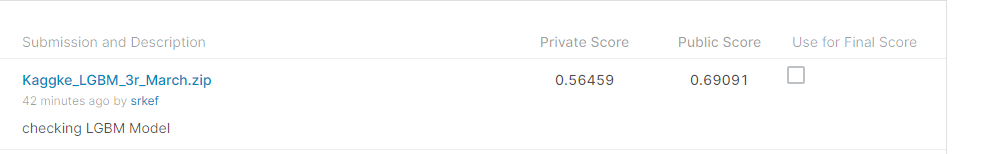

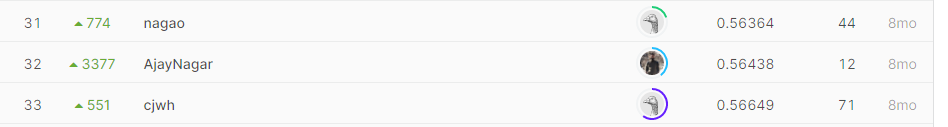

In [ ]:
# Got Rank Under 33.With Very Simple Approch in private LedgerBoard.

In [3]:
from prettytable import PrettyTable
t = PrettyTable(['Model_Number','Model_Name', 'Private Wrrmse Score','Public Wrrmse Score'])
t.add_row(['1', 'Base_Model',0.94398,1.00592])
t.add_row(['2', 'Random Forest Regressor',0.87519 ,0.78390])
t.add_row(['3','Extra Tree Regressor', .90082 ,0.81665])
t.add_row(['4', 'Lgbm',.56459 ,.69091])
print(t)

+--------------+-------------------------+----------------------+---------------------+
| Model_Number |        Model_Name       | Private Wrrmse Score | Public Wrrmse Score |
+--------------+-------------------------+----------------------+---------------------+
|      1       |        Base_Model       |       0.94398        |       1.00592       |
|      2       | Random Forest Regressor |       0.87519        |        0.7839       |
|      3       |   Extra Tree Regressor  |       0.90082        |       0.81665       |
|      4       |           Lgbm          |       0.56459        |       0.69091       |
+--------------+-------------------------+----------------------+---------------------+
